In [51]:
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.rosetta.core.id import *
from pyrosetta.rosetta.core.scoring.constraints import *
import pyrosetta.rosetta.protocols.simple_moves
from recces.data import *
import numpy as np
import itertools
import scipy
import scipy.linalg
import matplotlib
import matplotlib.pyplot as plt
init()
#init('-corrections::restore_talaris_behavior')

Found rosetta database at: /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database; using it....
PyRosetta-4 2017 [Rosetta PyRosetta4.Release.python27.ubuntu 2018.11+release.7c7790f7c7790fbb898f8210b54513b9f9c8a927c3e8d7f 2018-03-14T13:19:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.

core.init: Checking for fconfig files in pwd and ./rosetta/flags

core.init: Rosetta version: PyRosetta4.Release.python27.ubuntu r173 2018.11+release.7c7790f 7c7790fbb898f8210b54513b9f9c8a927c3e8d7f http://www.pyrosetta.org 2018-03-14T13:19:04
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2018.11+release.7c7790f-py2.7-linux-x86_64.egg/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=624484465 seed_offset=0 real_seed=624484465
core.init.random: RandomGenerator:i

In [52]:
pmm = PyMOLMover()
pmm.keep_history(True)


In [53]:
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner')
scorefxn_cst = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner')
scorefxn_cst.set_weight(core.scoring.dihedral_constraint, 1.0)
print scorefxn
curr_wt = [0.73, 0.1, 0.0071, 0, 4.26, 2.46, 0.25, 0, 1.54, 4.54]

ScoreFunction::show():
weights: (fa_atr 0.73) (fa_rep 0.1) (fa_intra_rep 0.0071) (lk_nonpolar 0.25) (fa_elec_rna_phos_phos 4.54) (rna_torsion 4.26) (stack_elec 1.54) (hbond_sc 2.46)
energy_method_options: EnergyMethodOptions::show: aa_composition_setup_files: 
EnergyMethodOptions::show: netcharge_setup_files: 
EnergyMethodOptions::show: aspartimide_penalty_value: 25
EnergyMethodOptions::show: etable_type: FA_STANDARD_DEFAULT
analytic_etable_evaluation: 1
EnergyMethodOptions::show: method_weights: free_res
EnergyMethodOptions::show: unfolded_energies_type: UNFOLDED_SCORE12
EnergyMethodOptions::show: split_unfolded_label_type: SPLIT_UNFOLDED_MM
EnergyMethodOptions::show: split_unfolded_value_type: SPLIT_UNFOLDED_BOLTZ
EnergyMethodOptions::show: atom_vdw_atom_type_set_name: centroid
EnergyMethodOptions::show: exclude_protein_protein_fa_elec: false
EnergyMethodOptions::show: exclude_RNA_RNA_fa_elec: false
EnergyMethodOptions::show: exclude_monomer_fa_elec: false
EnergyMethodOptions::show: 

In [54]:
def numpy_hessian(x, h):
        
    x_grad = np.gradient(x, h)
    hessian = np.empty((x.ndim, x.ndim) + x.shape, dtype = x.dtype)
    
    for k, grad_k in enumerate(x_grad):
        tmp_grad = np.gradient(grad_k, h)
        for l, grad_kl in enumerate(tmp_grad):
            hessian[k, l, :, :] = grad_kl
            
    return hessian

In [55]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [56]:
def within_360(dof):
    
    diff = dof/360.0
    diff = np.round(diff)
    
    return dof - 360.0*diff

In [57]:
def is_repeat_minimum(new_dofs, dof_lists):
    
    #dofs_rounded = np.around(new_dofs, decimals=1)
    
    if len(dof_lists) == 0:
        
        return False 
    
    for dof_list in dof_lists:
        
        #dof_list_rounded = np.around(dof_list, decimals=1)

        dof_diff = within_360(new_dofs) - within_360(dof_list)
        
        if np.all(abs(within_360(dof_diff)) < 20.0): return True
        else: continue
    
    return False

In [58]:
def chi_minima(base, sugar_pucker, orientation):

    if base == 'g' or base == 'a':

        if sugar_pucker == 'north':

            if orientation == 'anti': return [72.4]
            else: return [-110.9, -51.9]

        else:

            if orientation == 'anti': return [119.0]
            else: return [-56.6]
            
    else:

        if sugar_pucker == 'north':

            if orientation == 'anti': return [77.3]
            else: return [-105.7, -47.2, -12.5]

        else:

            if orientation == 'anti': return [108.2]
            else: return [-65.0]        
        


In [59]:
def initialiize_pose(seq):
    
    n_residues = len(seq)
    dof_dict = {}
    
    pose = pyrosetta.rosetta.protocols.recces.pose_setup_turner(seq, '')
    movemap = MoveMap()
    
    for ii in range(n_residues-1):
           
        dof_dict.update({5*ii: TorsionID(ii+1, BB, 5), 5*ii+1: TorsionID(ii+1, BB, 6), 5*ii+2: TorsionID(ii+2, BB, 1), 
                         5*ii+3: TorsionID(ii+2, BB, 2), 5*ii+4: TorsionID(ii+2, BB, 3)})
                        
        movemap.set(TorsionID(5*ii+1, BB, 5), True)
        movemap.set(TorsionID(5*ii+1, BB, 6), True)
        movemap.set(TorsionID(5*ii+2, BB, 1), True)
        movemap.set(TorsionID(5*ii+2, BB, 2), True)
        movemap.set(TorsionID(5*ii+2, BB, 3), True)
    
    for ii in range(n_residues):
    
        dof_dict.update({5*(n_residues-1) + ii: TorsionID(ii+1, CHI, 1)})
        movemap.set(TorsionID(ii+1, CHI, 1), True)
        
    return pose, movemap, dof_dict    
    

In [60]:
def calculate_hessian(pose, scorefxn, dof_dict):
    '''Take a minimized pose and computes the hessian at the base of the corresponding energy well. Returns the hessian matrix
    which may subsequently be diagonalized'''

    minimum = Pose()
    minimum.assign(pose)

    h = 0.1
    h_rad = h*np.pi/180
    E_0 = scorefxn(pose)

    dofs = []

    for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
    dofs = np.array(dofs)

    hessian = np.zeros((len(dofs), len(dofs)))

    n_pts = int(1/h + 1)
    ind = int(n_pts/2)

    tor_ranges = np.zeros((n_pts, len(dofs)))
    energy = np.zeros((n_pts, n_pts))

    for ii, dof in enumerate(dofs):

        tor_ranges[:, ii] = dof + np.arange(-0.5, 0.5+h, h)

    for pair in list(itertools.combinations(dof_dict.keys(), 2)):

        foo = pair[0]
        bar = pair[1]

        x = tor_ranges[:, foo]
        y = tor_ranges[:, bar]

        for ii, xx in enumerate(x):

            pose.set_torsion(dof_dict[pair[0]], xx)

            for jj, yy in enumerate(y):

                pose.set_torsion(dof_dict[pair[1]], yy)

                energy[ii, jj] = scorefxn(pose)

                pose.set_torsion(dof_dict[pair[1]], dofs[bar])

            pose.set_torsion(dof_dict[pair[0]], dofs[foo])

        hess = numpy_hessian(energy, h_rad)

        d2E_dx2 =  hess[0,0,:,:]
        d2E_dy2 =  hess[1,1,:,:]
        d2E_dxdy = hess[0,1,:,:]

        if hessian[foo, foo] == 0:

            hessian[foo, foo] = d2E_dx2[ind, ind]

        if hessian[bar, bar] == 0:

            hessian[bar, bar] = d2E_dy2[ind, ind]

        hessian[foo, bar] = d2E_dxdy[ind, ind]
        hessian[bar, foo] = d2E_dxdy[ind, ind]
        
    return hessian


In [61]:
def mode_scan(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = np.array([])
    
    h = np.arange(-60,61,1)

    for hh in h:
        
        dofs_new = dofs + hh*mode
        
        for key, val in enumerate(dofs_new):

            temp.set_torsion(dof_dict[key], val)
            
        result = np.append(result, (scorefxn(temp) - E_0)/kT)
     

    #if np.any(result < 0.0): return 1.0
    return np.trapz(np.exp(-result), x=h*np.pi/180.0), result


In [62]:
def mode_scan_OG(pose, dofs, dof_dict, scorefxn, mode, kT = 1.0, h = 0.5):
    
    temp = Pose()
    temp.assign(pose)
    
    E_0 = scorefxn(pose)
    E = E_0
    inc = 0
    result = 0.0
    
    max_inc = int(60/h)

    while inc < max_inc:
        
        inc += 1
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + (60.0)*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):

            temp.set_torsion(dof_dict[key], val)
        
        E = scorefxn(temp)
        if E < E_0: break
        result += 0.5*np.exp(-(E-E_0)/kT)

    if inc < max_inc: return 1.0
    # Reinitialize pose
    temp.assign(pose)
    inc = 0
    E = E_0
    
    while inc < max_inc:
        
        inc += 1
        
        result += 0.5*np.exp(-(E-E_0)/kT)
        dofs_new = dofs + 60.0*inc/float(max_inc)*mode
        
        for key, val in enumerate(dofs_new):
    
            temp.set_torsion(dof_dict[key], val)
        
        E  = scorefxn(temp)
        if E < E_0: break
        result += 0.5*np.exp(-(E-E_0)/kT)
        
    result *= h*np.pi/180.0
    
    if inc < max_inc: return 1.0
    return result


In [75]:
def assay_modes(pose, scorefxn, dof_dict):
    
    '''this code will assay the normal modes, plotting the corresponding boltzmann weights for both the harmonic approximation
    and scanned modes'''


    import scipy.integrate
    
    pose.assign(pose_min)
    print scorefxn(pose)

    hessian = calculate_hessian(pose, scorefxn, dof_dict)

    dofs = []

    for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
    dofs = np.array(dofs)

    w, v = scipy.linalg.eigh(hessian)



    E_min = scorefxn(pose)
    kT = 1.0
    fig = plt.figure()
    for kk, K in enumerate(w):

        mode = v[:,kk]
        h = np.arange(-80,81,1)
        h_plot = h*np.pi/180

        bar = []


        for hh in h:

            dofs_new = dofs+hh*mode

            for jj, dof in enumerate(dofs_new):

                pose.set_torsion(dof_dict[jj], dof)

            pmm.apply(pose)
            bar.append((scorefxn(pose)-E_min)/kT)


        np.array(bar) 
        pose.assign(minimum)
        plt.subplot(3,3, kk+1)

        #plt.plot(h, np.exp(-np.array(bar)))
        #plt.plot(h, np.exp(-0.5*K*h_plot**2/kT))
        
        plt.plot(h, np.array(bar))
        plt.plot(h, 0.5*K*h_plot**2/kT)
        plt.xticks([])
        plt.yticks([])
        #plt.xlabel('Displacement along normal coordinate (degrees)')
        #plt.ylabel('exp(-(E-E0)/kT)')


In [64]:
def add_constraints(pose):
    pose.add_constraint(
        core.scoring.constraints.DihedralConstraint(AtomID(11,2), AtomID(10,2), AtomID(23,2), AtomID(17, 2),
        core.scoring.func.CircularSigmoidalFunc(0.5, 6, pose.chi(2))))#CircularHarmonicFunc(pose.chi(2)*np.pi/180., 0.35)))
    pose.add_constraint(
        core.scoring.constraints.DihedralConstraint(AtomID(11,1), AtomID(10,1), AtomID(23,1), AtomID(17, 1),
        core.scoring.func.CircularSigmoidalFunc(0.5, 6, pose.chi(1))))#CircularHarmonicFunc(pose.chi(1)*np.pi/180., 0.35)))
    #pose.add_constraint(
    #    core.scoring.constraints.DihedralConstraint(AtomID(6,1), AtomID(8,1), AtomID(9,1), AtomID(1,2), 
    #    core.scoring.func.CircularHarmonicFunc(pose.epsilon(1)*np.pi/180., 0.35)))
    #pose.add_constraint(
    #    core.scoring.constraints.DihedralConstraint(AtomID(8,1), AtomID(9,1), AtomID(1,2), AtomID(4,2),
    #    core.scoring.func.CircularHarmonicFunc(pose.zeta(1)*np.pi/180., 0.35)))
    #pose.add_constraint(
    #    core.scoring.constraints.DihedralConstraint(AtomID(9,1), AtomID(1,2), AtomID(4,2), AtomID(5,2),
    #    core.scoring.func.CircularHarmonicFunc(pose.alpha(2)*np.pi/180., 0.35)))
    #pose.add_constraint(
    #    core.scoring.constraints.DihedralConstraint(AtomID(1,2), AtomID(4,2), AtomID(5,2), AtomID(6,2),
    #    core.scoring.func.CircularHarmonicFunc(pose.beta(2)*np.pi/180., 0.25)))
    #pose.add_constraint(
    #    core.scoring.constraints.DihedralConstraint(AtomID(4,2), AtomID(5,2), AtomID(6,2), AtomID(8,2),
    #    core.scoring.func.CircularHarmonicFunc(pose.gamma(2)*np.pi/180., 0.25)))

    return pose

In [65]:
def MC_minimization(pose, scorefxn, dof_dict, torsion_list):
    
    import random
    mc = MonteCarlo(pose, scorefxn, 0.5)
    
    for i in range(100):

        dof = random.randint(0, len(torsion_list)-1)
        #new_dof = random.uniform(torsion_list[dof] - 30.0, torsion_list[dof] + 30.0)
        new_dof = random.gauss(torsion_list[dof], 20.)
        pose.set_torsion(dof_dict[dof], new_dof)
        mc.boltzmann(pose)
    
    return mc.lowest_score_pose()
    

In [80]:
seq = 'gc'

# Pucker and orientation of terminal base
pucker = 'south'
orientation = 'anti'

n = len(seq)
Z_harm_list = np.array([])
mu_list = np.array([])
pmm = PyMOLMover()
pmm.keep_history(True)
dof_lists = []
E_list = np.array([])
E_min = 0
pose_min = Pose()
dofs_min = []
print dof_lists

[]


In [82]:
# Code for any dinucleotide 
for delta in [81.195, 145.521]:
    
    for alpha in [-64.3, 66.7, 156.6]:
        
        pose, movemap, dof_dict = initialiize_pose(seq)
        
        pose.set_torsion(TorsionID(1, BB, 4), delta)
    
        if delta == 81.195:

            if seq[0] in 'ga': possible_chi = [-110.9, -51.9, 72.4]
            else: possible_chi = [-105.7, -47.2, -12.5, 77.3]
                    
            possible_eps = [-150.4, 16.8, 76.2]

        #C2'-endo
        else:

            if seq[0] in 'ga': possible_chi = [-56.6, 119.0]
            else: possible_chi =[-65, 108]
                
            possible_eps = [-97.4, 0, 75.2]
            
            pose.set_torsion(TorsionID(1, CHI, 2), -34.825)
            pose.set_torsion(TorsionID(1, CHI, 3), 155.987)
                
        #if pucker == 'north':
        
            #pose.set_torsion(TorsionID(2, BB, 4), 81.195)
            #pose.set_torsion(TorsionID(2, CHI, 2), 35.870)
            #pose.set_torsion(TorsionID(2, CHI, 3), 94.856)
            
        if pucker == 'south':
        
            # These will set the terminal base pair to C2'-endo (south)
            pose.set_torsion(TorsionID(2, BB, 4), 145.521)
            pose.set_torsion(TorsionID(2, CHI, 2), -34.79)
            pose.set_torsion(TorsionID(2, CHI, 3), 156.00)

        if alpha == -64.3: possible_zeta = [-71.8, 167.55]
        elif alpha == 66.7: possible_zeta = [-131.6, 79.0]
        else: possible_zeta = [-69.5, 56.5]
        
        possible_chi_2 = chi_minima(seq[-1], pucker, orientation)
        torsion_lists = itertools.product(possible_eps, possible_zeta, [alpha], [177.3], [175.8, 53.5, -62.9], possible_chi, 
                                          possible_chi_2)
        
        
        
        for torsion_list in list(torsion_lists):
            
            pose.set_torsion(TorsionID(1, BB, 5), torsion_list[0])
            pose.set_torsion(TorsionID(1, BB, 6), torsion_list[1])
            pose.set_torsion(TorsionID(2, BB, 1), torsion_list[2])
            pose.set_torsion(TorsionID(2, BB, 2), torsion_list[3])
            pose.set_torsion(TorsionID(2, BB, 3), torsion_list[4])
            pose.set_torsion(TorsionID(1, CHI, 1), torsion_list[5])
            pose.set_torsion(TorsionID(2, CHI, 1), torsion_list[6])

            pmm.apply(pose)
            
            pose = add_constraints(pose)
            
            pose = MC_minimization(pose, scorefxn, dof_dict, torsion_list)
            
            minmover = rosetta.protocols.minimization_packing.MinMover(
                movemap, scorefxn, 'dfpmin_armijo_nonmonotone', 1.0e-7, True)
            minmover.max_iter(1000000)
            minmover.min_options().use_nblist(True)
            minmover.min_options().nblist_auto_update(True)
            minmover.apply(pose)

            pmm.apply(pose)
            E_min = scorefxn(pose)
            
            minimum = Pose()
            minimum.assign(pose)

            dofs = []

            for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
            dofs.append(delta)
            dofs = np.array(dofs)


            if is_repeat_minimum(dofs, dof_lists): continue
            dof_lists.append(dofs)
                    
            hessian = calculate_hessian(pose, scorefxn, dof_dict)
            w,v = scipy.linalg.eigh(hessian)

            if not np.all(w > 0.):
                continue

            E_list = np.append(E_list, E_min)
            
            Z = 1.0
            Z_harm = np.sqrt((2*np.pi)**len(w)/scipy.linalg.det(hessian)) 
            
            for kk, K in enumerate(w):

                fuck,_ = mode_scan(pose, dofs[:-1], dof_dict, scorefxn, v[:, kk])
                
                if fuck == 1.0: break
                    
                Z *= fuck

            if kk < 6:
                
                dof_lists.pop()
                E_lists = np.delete(E_list, -1)
                E_min = 0
                
                continue
            
            if np.all(E_list >= E_min):
                
                pose_min.assign(minimum)
                dofs_min = dofs
                
            #Z_list = np.append(Z_list, np.exp(-scorefxn(minimum)/0.6163)*Z )
            Z_harm_list = np.append(Z_harm_list, np.exp(-scorefxn(minimum))*Z_harm)
            mu_list = np.append(mu_list, scorefxn(minimum) - np.log(Z))
            print (scorefxn(minimum) - np.log(Z))*0.6163, Z, scorefxn(minimum)
            #print -0.6163*np.log(np.sum(np.exp(-mu_list/0.6163))), scorefxn(minimum), np.exp(-(scorefxn(minimum) - np.log(Z))/0.6163)

'''
# South, anti
pose.set_torsion(TorsionID(1, BB, 4), 145.4)
pose.set_torsion(TorsionID(1, BB, 5), -97.4)
pose.set_torsion(TorsionID(1, CHI, 1), -56.6)
pose.set_torsion(TorsionID(1, CHI, 2), -37.2)
pose.set_torsion(TorsionID(1, CHI, 3), 155.5)
pose.set_torsion(TorsionID(2, BB, 1), 66.7)
pose.set_torsion(TorsionID(2, BB, 3), -62.9)
pose.set_torsion(TorsionID(2, BB, 4), 145.4)
pose.set_torsion(TorsionID(2, CHI, 1), -56.6)
pose.set_torsion(TorsionID(2, CHI, 2), -37.2)
pose.set_torsion(TorsionID(2, CHI, 3), 155.5)
'''


5.63872747477602 0.007697914578185285 4.28251670844
6.114970454091746 0.000270368408351832 1.70634285824
1.5736806243495371 0.00022455540309227091 -5.84795531355
6.087111130894029 2.6227195360710156 10.8410755232
6.890334974899327 0.009352937309693124 6.50809900625
2.073828873070267 0.4641336438269467 2.59738378829

6.108894308986664 0.26031866602061154 8.56636008154


KeyboardInterrupt: 

In [83]:
import scipy.special
print 0.6163*(-scipy.special.logsumexp(-mu_list[:]))
print -0.6163*np.log(np.sum(Z_harm_list))
fuck = Z_list*(2*np.pi/3)**7
print -0.6163*np.log(np.sum(fuck))
print -0.6163*np.log(np.sum(Z_list)) 
print np.sum(Z_list)
print np.sum(Z_list*(2*np.pi/3)**7)
print len(Z_list)
print -0.6163*np.log(np.sum(Z_list))
print np.sum(Z_harm_list)
print np.sum(Z_list) 
print Z_harm_list

1.2562035073306506
1.5252245567715386


NameError: name 'Z_list' is not defined

[-139.00541338  173.10772004  -59.80145199  138.5140186    57.66049358
 -110.72395945  112.45587982   81.195     ]
-5.84795531355


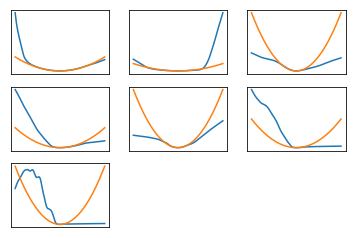

In [84]:
print dofs
assay_modes(pose, scorefxn, dof_dict)

In [49]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation().fit(dof_lists)

pose = protocols.recces.pose_setup_turner(seq,'')

In [50]:
print len(dof_lists), len(af.cluster_centers_indices_)

8 3


In [ ]:
def set_pucker(pose, idx, pucker='north'):
    
    if pucker == 'north': return pose
    
    if pucker =='south':
        
        pose.set_torsion(TorsionID(idx, BB, 4), 145.521)
        pose.set_torsion(TorsionID(idx, CHI, 2), -34.79)
        pose.set_torsion(TorsionID(idx, CHI, 3), 156.00)
        
        return pose

In [41]:
cluster_center_indices = af.cluster_centers_indices_
shit_list = []

for k in cluster_center_indices:
    
    dofs = dof_lists[k]
    for kk, dof in enumerate(dofs): pose.set_torsion(dof_dict[kk], dof)
    hessian = calculate_hessian(pose, scorefxn, dof_dict)
    pmm.apply(pose)
    w,v = scipy.linalg.eigh(hessian)
   
    shit = 1.0
    for kk, K in enumerate(w):
        
        fuck = mode_scan(pose, dofs, dof_dict, scorefxn, v[:,kk])
        shit *= fuck
    
    shit_list.append(shit)

/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()


In [42]:
print shit_list

[1.5500664848930115, 0.1007467642511247, 0.09945661861583122, 7.088120296095544e+35, inf, 43.09028650480836, 0.01907815267870834, 1.45919983556947, 0.030081473835010333, 0.18468192165534247, 0.08953196370822086, 7.952383976313734e+53, inf, 34052109.47872202, 3.62466377086807, 7.290019313431219e+39, 44940480205.3906, 3.834591523137687e+16, 2.09098130666092, 6248.739562805799, 91751142.89854813, 10783.35318247478, 165849.52718728004, 4400.03466638504]


-0.9376301833576508
north anti -10.668623055975846


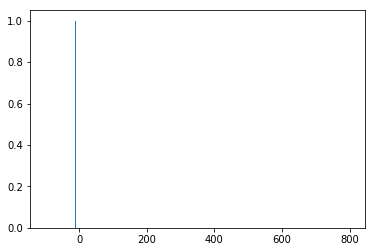

In [224]:
hist = plt.hist(E_list,bins=9000,range=(-100,800))
print -0.6163*np.log(np.sum(np.exp(-mu_list)))

print pucker, orientation, min(E_list)

In [184]:
print scorefxn(pose_min) - 0.6163*np.log(configuration_integral)
print configuration_integral
print -0.6163*np.log(np.exp(-scorefxn(pose_min)/0.6163)*configuration_integral) 
print -0.6163*scipy.special.logsumexp(-mu_list)
print -0.6163*np.log(np.exp(-scorefxn(pose_min)/0.6163)*configuration_integral)
print scorefxn(pose_min) - np.log(configuration_integral)
print (np.exp(-(scorefxn(pose_min)-np.log(configuration_integral))/0.6163))


NameError: name 'configuration_integral' is not defined

In [229]:
pose = pose_from_file('./../recces_rosetta/results/ag/infile_80/prerun/ag.pdb')
huh = pose_min
print scorefxn(pose)
pmm.apply(pose)
pose.assign(pose_min)
minmover.apply(pose)
pmm.apply(pose)
hessian = calculate_hessian(pose_min, scorefxn, dof_dict)
print scorefxn(pose_min)
dofs = []
for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
dofs = np.array(dofs)

core.import_pose.import_pose: File './../recces_rosetta/results/ag/infile_80/prerun/ag.pdb' automatically determined to be of type PDB
-9.99619953834
-10.668623056


In [230]:
w, v = scipy.linalg.eigh(hessian)
obs = protocols.moves.AddPyMOLObserver(pose, True)
pose.assign(huh)
E_min = scorefxn(pose_min)
print E_min
print pose_min.alpha(2)

-10.668623056
-61.9851471746


In [416]:
print 0.5*np.log(scipy.linalg.det(hessian))- 0.5*len(w)*np.log(2*np.pi) + scorefxn(pose_min)

-1.6243333348616762


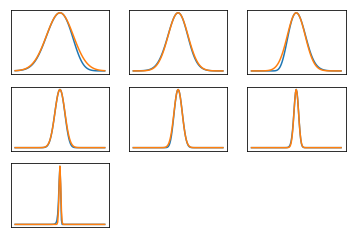

In [389]:
import scipy.integrate

Z = 1

pose.assign(pose_min)
E_min = scorefxn(pose_min)
kT = 1.0
for kk in range(len(w)):
 
    mode = v[:,kk]
    h = np.arange(-60,61,1)
    #fuck = h[:-1]
    #fuck.reverse()
    #h = h+fuck
    #h = np.array(h)
    h_plot = h*np.pi/180

    bar = []


    for hh in h:

        dofs_new = dofs+hh*mode

        for jj, dof in enumerate(dofs_new):

            pose.set_torsion(dof_dict[jj], dof)

        bar.append((scorefxn(pose)-E_min)/kT)

    
    Z *= np.trapz(np.exp(-np.array(bar)), x = h_plot)
    np.array(bar) 
    pose.assign(pose_min)
    
    plt.subplot(3, 3, kk+1)
    plt.plot(h, np.exp(-np.array(bar)))
    plt.plot(h, np.exp(-0.5*w[kk]*h_plot**2/kT))
    plt.xticks([],[])
    plt.yticks([],[])
    #plt.xlabel('Displacement along normal coordinate (degrees)')
    #plt.ylabel('exp(-(E-E0)/kT)')

In [390]:
print (scorefxn(pose_min) - np.log(Z))*0.6163

-0.9317799003971552
-10.668623056
9.156729659258085


In [398]:
sim = SingleHistSimulation('./../../das-lab/recces_rosetta/results/ag/infile_120/ST/')
print 0.6163*(sim.value) - 0.6163*np.log(4*np.pi/3)*7

No phase space volume applied
-0.9492145449075741


In [234]:
print min(E_list)
pmm.apply(pose_min)

-10.668623055975846


In [192]:
pmm.apply(pose_min)

In [193]:
pose = protocols.recces.pose_setup_turner('g','')
print pose.epsilon(1)

0.0


In [ ]:
minmover.tolerance(1e-7)
minmover.max_iter(100000)
minmover.apply(pose)


In [ ]:
print dof_lists

In [28]:
print dof_dict
from scipy.special import gamma
from scipy.special import logsumexp
#north_anti_min.assign(pose_min)
print scorefxn(pose_min)

{0: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f8544988768>, 1: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f8544988810>, 2: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f8544988570>, 3: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f85449885e0>, 4: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f8544988500>, 5: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f85449885a8>, 6: <pyrosetta.rosetta.core.id.TorsionID object at 0x7f8544988068>}
-10.0049722639


In [65]:
hessian = calculate_hessian(pose_min, scorefxn, dof_dict)
print np.linalg.det(hessian)
from recces.util import *
from recces.data import *


12215866453535.832


In [420]:
from recces.util import *
from recces.data import *
sim = SingleHistSimulation('./../recces_rosetta/results/ag/infile_120/ST/', name='')
print (sim.value)*0.6163 - 0.6163*np.log(4*np.pi/3)*7
print (scorefxn(pose_min) - np.log(Z) - np.log(2*np.pi/3)*7)*0.6163

No phase space volume applied
-1.8035877596657626
-4.12104207805062


In [417]:
print (scorefxn(pose_min) + 0.5*np.log(np.linalg.det(hessian)) - 3.5*np.log(2*np.pi))*0.6163 - np.log(2*np.pi/3)*7*0.6163
print (scorefxn(pose_min) + 0.5*np.log(np.linalg.det(hessian)) - 3.5*np.log(2*np.pi))*0.6163
E_min = scorefxn(pose_min)
sim = SingleHistSimulation('./../recces_rosetta/results/ag/infile_120/ST/',name='')



-4.190338811928716
-1.001076634275251
No phase space volume applied


12/17 
Need to figure out why SingleSimulation and SingleHistSimulation are giving different values of the free energy. SingleHistSimulation seems to be agreeing with MM while SingleSimulation is off by 2*log(2)

In [400]:
matt_guess = lambda E: (2.0*np.pi)**(len(w)/2)*(E-E_min)**(len(w)/2 - 1)/gamma(len(w)/2)/np.sqrt(np.linalg.det(hessian))*np.heaviside(E-E_min, 0.5)#2*(2*np.pi)**((len(w)-1)/2)*(2*(E-E_min))**(len(w)/2-1)/scipy.misc.factorial2(len(w)-2)/np.sqrt(np.linalg.det(hessian))*np.heaviside(E-E_min,0.5)

Text(0,0.5,'$g(E)e^{\\frac{-E}{kT}}$')

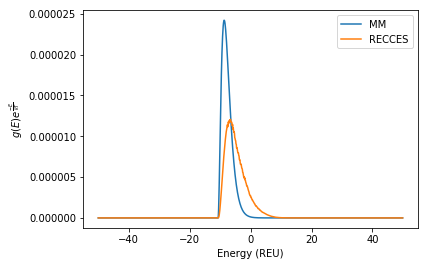

In [408]:
plt.plot(hist[1][500:1500], matt_guess(hist[1][500:1500])*np.exp(-hist[1][500:1500])/(4*np.pi/3)**7)
#plt.plot(hist[1][500:1500], matt_guess_ns(hist[1][500:1500])*np.exp(-hist[1][500:1500]))
#plt.plot(hist[1][500:1500], matt_guess_sa(hist[1][500:1500])*np.exp(-hist[1][500:1500]))
#plt.plot(hist[1][500:1500], matt_guess_ss(hist[1][500:1500])*np.exp(-hist[1][500:1500]))
plt.plot(sim._dos_scores[500:1500], np.exp(-sim._dos_scores[500:1500])*sim._dos[500:1500])
plt.legend(['MM','RECCES'])
plt.xlabel('Energy (REU)')
plt.ylabel(r'$g(E)e^{\frac{-E}{kT}}$')

12/16

Plot log of the density of states. Compare both harmonic approximation with simulated tempering estimation. Consistent with discrepancies in estimated free energies, there appears to be a constant offset of about 2*log(2). Unclear why this is the case. Perhaps has something to do with normalizatiotn and configuration space volume calculated by recces results processing scripts. Will need to alter that code and follow up on this investigation.

Pure harmonic approximation with correction for finite phase volume seems to be giving best approximation

/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


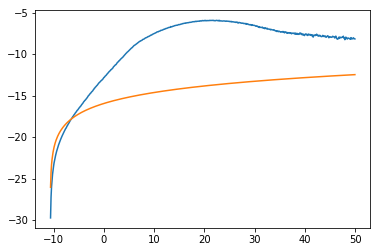

In [422]:
plt.plot(hist[1][500:1500], np.log(sim._dos[500:1500]))
plt.plot(hist[1][500:1500], np.log(matt_guess(hist[1][500:1500]))-np.log(4*np.pi/3)*7)


In [424]:
print -0.6163*logsumexp(-hist[1][:], b=matt_guess(hist[1][:]))
print sim.value*0.6163 - 0.6163*np.log(4*np.pi/3)*7

-1.8538222213906013
-1.8035877596657626


/home/maa/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  """Entry point for launching an IPython kernel.


In [252]:
pose_min.dump_pdb('./../recces_rosetta/results/ag/infile/prerun/ag.pdb')

True

In [248]:
print pose.torsion(TorsionID(2, BB, 4)), pose.torsion(TorsionID(1, CHI, 2))

81.1757667609 35.8538883447


In [ ]:
scorefxn(pose)

In [ ]:
print hist[1]

In [ ]:
print pose.alpha(2), pose.beta(2), pose.gamma(2), pose.delta(1), pose.epsilon(1), pose.zeta(1)

In [ ]:
huh = pose_from_file('./../recces_rosetta/results/min.pdb')
print huh.torsion(TorsionID(1, CHI, 2)), huh.torsion(TorsionID(1, CHI, 3))

In [ ]:
print 
pmm.apply(huh)
print huh.epsilon(1), huh.zeta(1), huh.alpha(2), huh.beta(2), huh.gamma(1), huh.delta(2), huh.chi(1), huh.chi(2)

In [ ]:
print huh.alpha(2), huh.beta(2), huh.gamma(2), huh.epsilon(1), huh.zeta(1)

In [ ]:
scorefxn(huh)

In [ ]:
pose.set_ring_conformation('north')

In [ ]:
print pose.

In [ ]:
pose = pose_from_file('./../../das-lab/recces_rosetta/results/ag/ST/ST_637000.pdb')

In [ ]:
print pose.delta(1), pose.torsion(TorsionID(1, CHI, 2)), pose.torsion(TorsionID(1, CHI, 3))
print pose.delta(2), pose.torsion(TorsionID(2, CHI, 2)), pose.torsion(TorsionID(2, CHI, 3))

In [ ]:
# ag/ST/367000, 38000

# C2'-endo
print 145.521118169, -34.8252844774, 155.978251202

# C3'-endo
print 81.1950530464, 35.8703398534, 94.8555221911

In [ ]:
pose = protocols.recces.pose_setup_turner('gg','')

In [ ]:
pmm.apply(pose)
pose.set_torsion(TorsionID(1, BB, 4), 145.5)
pose.set_torsion(TorsionID(1, CHI, 2), -34.8)
pose.set_torsion(TorsionID(1, CHI, 3), 155.98)

In [ ]:
pmm.apply(pose)

In [ ]:
pose.set_chi(1, -56.6)

In [ ]:
pmm.apply(pose)

In [ ]:
print -0.6163*(np.log(90260*2+108.954*2) + 7*np.log(2*np.pi/3) + 2*np.log(2))

In [ ]:
pmm.apply(pose_min)

In [ ]:
print scorefxn(pose_min)

In [ ]:
print E_list

In [ ]:
print min(E_list)


In [ ]:
print E_min

In [ ]:
print rna_hires(pose_min)

In [ ]:
pmm.apply(pose_min)

In [ ]:
print pose_min.epsilon(1), pose_min.zeta(1), pose_min.alpha(2), pose_min.beta(2), pose_min.gamma(2)
print pose_min.delta(1), pose_min.delta(2)

In [ ]:
pose_min.dump_pdb('./../gg_fuck.pdb')

In [ ]:
pose = pose_from_file('./../gg.pdb')
pmm.apply(pose)

In [ ]:
options = scorefxn.energy_method_options()
print options.hbond_options()
options.etable_options().no_lk_polar_desolvation = False
scorefxn.set_energy_method_options(options)
scorefxn.show(pose)

In [ ]:
pmm.apply(pose)


In [ ]:
 print 0.6163*(-np.log(2*90206 + 2*108.954) - 7*np.log(2*np.pi/3) - 2*np.log(2))

In [ ]:
print movemap


In [ ]:
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner')

In [ ]:
print scorefxn

In [ ]:
scorefxn.show(pose_min)

In [ ]:
print pose

In [ ]:
print pose.chi(1)

In [ ]:
N9 = AtomID(1, 19)
C1 = AtomID(1, 8)

In [ ]:
pose.conformation().bond_length(C1, N9)

In [ ]:
print pose

In [ ]:
pyrosetta.rosetta.protocols.constraint_generator

In [ ]:
import pyrosetta.rosetta.protocols.moves.ConstraintSetMover()

In [ ]:
fuck = ConstraintSetMover()

In [ ]:
fuck.set_id(TorsionID(1, CHI, 1))

In [ ]:
print pose.residue(1)

In [ ]:
import pyrosetta.rosetta.protocols.simple_moves

In [ ]:
set_constraint = pyrosetta.rosetta.protocols.simple_moves.ConstraintSetMover()

In [ ]:
set_constraint.constraint_file('./cst_file.cst')
dihedral_constraint_function = core.scoring.func.CircularHarmonicFunc(pose.chi(2), 0.35)
shit = core.scoring.constraints.DihedralConstraint(core.id.AtomID(1,1), core.id.AtomID(1,2), core.id.AtomID(1,3), core.id.AtomID(1,4), dihedral_constraint_function)

In [ ]:
pose = protocols.recces.pose_setup_turner('gg','')
pose.dump_pdb('shit.pdb')
print core.id.AtomID(23,1)
print pose.residue(2).atom(17)

In [ ]:
atom = pose.residue(2).atom_index('C3\'')
print atom

In [ ]:
atom1 = core.id.AtomID(2, 5)

In [ ]:
print pose.conformation().dof_id_from_torsion_id(TorsionID(2, CHI, 1))

In [ ]:
north_anti_min = Pose()
north_anti_min.assign(pose_min)

In [ ]:
north_syn_min = Pose()
north_syn_min.assign(pose_min)

In [ ]:
south_syn_min = Pose()
south_syn_min.assign(pose_min)

In [ ]:
south_anti_min = Pose()
south_anti_min.assign(pose_min)

In [ ]:
pose.set_epsilon(1, -145.65)
pose.set_zeta(1, -62.90)
pose.set_alpha(2, -55.65)
pose.set_beta(2, 168.81)
pose.set_gamma(2, 65.70)
pose.set_chi(1, 67.90)
pose.set_chi(2, 113.39)

pmm.apply(pose)

In [ ]:
pmm.apply(pose_min)

In [ ]:
pose = protocols.recces.pose_setup_turner('ga','')

In [ ]:
ST_min = pose_from_file('./../gg_fuck.pdb')
print scorefxn(pose_min)
print scorefxn(ST_min)

In [ ]:
#print ST_min.torsion(TorsionID(2, CHI, 1))
#print ST_min.torsion(TorsionID(2, CHI, 2))
#print ST_min.torsion(TorsionID(2, CHI, 3))
print ST_min.epsilon(1)
print ST_min.zeta(1)
print ST_min.alpha(2)
print ST_min.beta(2)
print ST_min.gamma(2)
print ST_min.chi(1)
print ST_min.chi(2)
minmover.apply(ST_min)
scorefxn(ST_min)

In [ ]:
pose.set_epsilon(1, -150.4)
pose.set_zeta(1, 56.5)
pose.set_alpha(2, 156.6)
pose.set_beta(2, 177.3)
pose.set_gamma(2, 53.5)
pose.set_chi(1, 72.4)
pose.set_chi(2, 119.0)

In [ ]:
scorefxn(ST_min)

In [ ]:
minmover.apply(ST_min)
scorefxn(ST_min)

In [ ]:
print pose.epsilon(1)
print pose.zeta(1)
print pose.alpha(2)
print pose.beta(2)
print pose.gamma(2)
print pose.chi(1)
print pose.chi(2)

In [264]:
pose_min.dump_pdb('./../../das-lab/recces_rosetta/results/ag/infile_80/prerun/ag.pdb')

True

In [262]:
print scorefxn(pose_min)

-10.668623056


12/17

Below is code to run MM on trinucleotides. This is prohibitive to run on a local machine--must figure out how to run on cluster etc. 

In [ ]:
seq = 'ggg'

# Pucker and orientation of terminal base
pucker = 'north'
orientation = 'anti'

n = len(seq)
Z_harm_list = np.array([])
mu_list = np.array([])
pmm = PyMOLMover()
pmm.keep_history(True)
dof_lists = []
E_list = np.array([])
E_min = 0
pose_min = Pose()
dofs_min = []

In [ ]:
# Code for any trinucleotide 
for delta in [81.195, 145.521]:
    
    for alpha in [-64.3, 66.7, 156.6]:
        
        pose, movemap, dof_dict = initialiize_pose(seq)
        
        pose.set_torsion(TorsionID(1, BB, 4), delta)
    
        if delta == 81.195:

            if seq[0] in 'ga': possible_chi = [-110.9, -51.9, 72.4]
            else: possible_chi = [-105.7, -47.2, 77.3]
                    
            possible_eps = [-150.4, 16.8, 76.2]

        #C2'-endo
        else:

            if seq[0] in 'ga': possible_chi = [-56.6, 119.0]
            else: possible_chi =[-65, 108]
                
            possible_eps = [-97.4, 0, 75.2]
            
            pose.set_torsion(TorsionID(1, CHI, 2), -34.825)
            pose.set_torsion(TorsionID(1, CHI, 3), 155.987)
                
        #if pucker == 'north':
        
            #pose.set_torsion(TorsionID(2, BB, 4), 81.195)
            #pose.set_torsion(TorsionID(2, CHI, 2), 35.870)
            #pose.set_torsion(TorsionID(2, CHI, 3), 94.856)

        if alpha == -64.3: possible_zeta = [-71.8, 167.55]
        elif alpha == 66.7: possible_zeta = [-131.6, 79.0]
        else: possible_zeta = [-69.5, 56.5]
        
               
        for delta_2 in [81.195, 145.521]:
        
            for alpha_2 in [-64.3, 66.7, 156.6]:
                
                pose.set_torsion(TorsionID(2, BB, 4), delta_2)
                
                if delta_2 == 81.195:

                    if seq[1] in 'ga': possible_chi_2 = [-110.9, -51.9, 72.4]
                    else: possible_chi_2 = [-105.7, -47.2, 77.3]
                    
                    possible_eps_2 = [-150.4, 16.8, 76.2]
                    
                else:

                    if seq[1] in 'ga': possible_chi_2 = [-56.6, 119.0]
                    else: possible_chi_2 =[-65, 108]
                
                    possible_eps_2= [-97.4, 0, 75.2]
            
                    pose.set_torsion(TorsionID(2, CHI, 2), -34.825)
                    pose.set_torsion(TorsionID(2, CHI, 3), 155.987)

                if alpha_2 == -64.3: possible_zeta_2 = [-71.8, 167.55]
                elif alpha_2 == 66.7: possible_zeta_2 = [-131.6, 79.0]
                else: possible_zeta_2 = [-69.5, 56.5]
        

                if pucker == 'south':
        
                    # These will set the terminal base pair to C2'-endo (south)
                    pose.set_torsion(TorsionID(3, BB, 4), 145.521)
                    pose.set_torsion(TorsionID(3, CHI, 2), -34.79)
                    pose.set_torsion(TorsionID(3, CHI, 3), 156.00)
                
                
                possible_chi_3 = chi_minima(seq[-1], pucker, orientation)
                
                torsion_lists = itertools.product(possible_eps, possible_zeta, [alpha], [177.3], [175.8, 53.5, -62.9],
                                                  possible_eps_2, possible_zeta_2, [alpha_2], [177.3], [175.8, 53.5, -62.9],
                                                  possible_chi, possible_chi_2, possible_chi_3)

                
                for torsion_list in list(torsion_lists):

                    pose.set_torsion(TorsionID(1, BB, 5), torsion_list[0])
                    pose.set_torsion(TorsionID(1, BB, 6), torsion_list[1])
                    pose.set_torsion(TorsionID(2, BB, 1), torsion_list[2])
                    pose.set_torsion(TorsionID(2, BB, 2), torsion_list[3])
                    pose.set_torsion(TorsionID(2, BB, 3), torsion_list[4])
                    pose.set_torsion(TorsionID(2, BB, 5), torsion_list[5])
                    pose.set_torsion(TorsionID(2, BB, 6), torsion_list[6])
                    pose.set_torsion(TorsionID(3, BB, 1), torsion_list[7])
                    pose.set_torsion(TorsionID(3, BB, 2), torsion_list[8])
                    pose.set_torsion(TorsionID(3, BB, 3), torsion_list[9])
                    
                    pose.set_torsion(TorsionID(1, CHI, 1), torsion_list[10])
                    pose.set_torsion(TorsionID(2, CHI, 1), torsion_list[11])
                    pose.set_torsion(TorsionID(3, CHI, 1), torsion_list[12])

                    pmm.apply(pose)

                    pose = add_constraints(pose)

                    #pose = MC_minimization(pose, scorefxn, dof_dict, torsion_list)

                    minmover = rosetta.protocols.minimization_packing.MinMover(
                        movemap, scorefxn, 'dfpmin_armijo_nonmonotone', 1.0e-7, True)
                    minmover.max_iter(1000000)
                    minmover.min_options().use_nblist(True)
                    minmover.min_options().nblist_auto_update(True)
                    minmover.apply(pose)

                    pmm.apply(pose)
                    E_min = scorefxn(pose)

                    minimum = Pose()
                    minimum.assign(pose)

                    dofs = []

                    for val in dof_dict.itervalues(): dofs.append(pose.torsion(val))
                    dofs = np.array(dofs)


                    #if is_repeat_minimum(dofs, dof_lists): continue

                    dof_lists.append(dofs)

                    hessian = calculate_hessian(pose, scorefxn, dof_dict)
                    w,v = scipy.linalg.eigh(hessian)

                    if not np.all(w > 0.):
                        continue

                    E_list = np.append(E_list, E_min)

                    Z = 1.0
                    Z_harm = np.sqrt((2*np.pi)**len(w)/scipy.linalg.det(hessian)) 

                    for kk, K in enumerate(w):

                        fuck = mode_scan(pose, dofs, dof_dict, scorefxn, v[:, kk])

                        if fuck == 1.0: break

                        Z *= fuck

                    if kk < 6:

                        dof_lists.pop()
                        E_lists = np.delete(E_list, -1)
                        E_min = 0

                        continue

                    if np.all(E_list >= E_min):

                        pose_min.assign(minimum)
                        dofs_min = dofs

                    #Z_list = np.append(Z_list, np.exp(-scorefxn(minimum)/0.6163)*Z )
                    Z_harm_list = np.append(Z_harm_list, np.exp(-scorefxn(minimum))*Z_harm)
                    mu_list = np.append(mu_list, scorefxn(minimum) - np.log(Z))
                    print scorefxn(minimum) - np.log(Z), Z, scorefxn(minimum)
                    #print -0.6163*np.log(np.sum(np.exp(-mu_list/0.6163))), scorefxn(minimum), np.exp(-(scorefxn(minimum) - np.log(Z))/0.6163)

        '''
        # South, anti
        pose.set_torsion(TorsionID(1, BB, 4), 145.4)
        pose.set_torsion(TorsionID(1, BB, 5), -97.4)
        pose.set_torsion(TorsionID(1, CHI, 1), -56.6)
        pose.set_torsion(TorsionID(1, CHI, 2), -37.2)
        pose.set_torsion(TorsionID(1, CHI, 3), 155.5)
        pose.set_torsion(TorsionID(2, BB, 1), 66.7)
        pose.set_torsion(TorsionID(2, BB, 3), -62.9)
        pose.set_torsion(TorsionID(2, BB, 4), 145.4)
        pose.set_torsion(TorsionID(2, CHI, 1), -56.6)
        pose.set_torsion(TorsionID(2, CHI, 2), -37.2)
        pose.set_torsion(TorsionID(2, CHI, 3), 155.5)
        '''

In [ ]:
fuck = pose_from_file('./../recces_rosetta/results/gg/infile/prerun/min.pdb')
print scorefxn(fuck)

shit = pose_from_file('./../recces_rosetta/results/gg/infile/ST/min.pdb')
print scorefxn(shit)


print scorefxn(pose_min)

In [ ]:
pose_min.set_secstruct(1,'L')
pose_min.set_secstruct(2,'L')
scorefxn.show(pose_min)
scorefxn.show(fuck)


In [205]:
pose_min.dump_pdb('./../recces_rosetta/results/aa/infile/prerun/aa.pdb')

True

In [ ]:
print shit.annotated_sequence()

In [ ]:
pose = protocols.recces.pose_setup_turner('gg','')


In [ ]:
print pose.fold_tree()
pose.set_secstruct(1,'L')
pose.set_secstruct(2,'L')
print pose.secstruct()
pose2 = pose_from_file('./../recces_rosetta/results/gg/infile/ST/min.pdb')

In [ ]:
print pose2.fold_tree().is_cutpoint(1)

In [ ]:
ft = pose.fold_tree()
ft.clear()
print ft
ft.add_edge(1, 2, 1)
print ft

In [ ]:
pose2.fold_tree(ft)
scorefxn(pose)
scorefxn.show(pose2)

In [160]:
pmm.apply(pose_min)

In [ ]:
print pose.annotated_sequence()

In [ ]:
pose.dump_pdb('./../recces_rosetta/results/gg/infile/prerun/gg.pdb')

In [ ]:
print scorefxn(pose)

In [198]:
pose = pose_from_file('./../recces_rosetta/results/ag/infile/prerun/min.pdb')

core.import_pose.import_pose: File './../recces_rosetta/results/ag/infile/prerun/min.pdb' automatically determined to be of type PDB


In [199]:
pmm.apply(pose)
pmm.apply(pose_min)